## Dataset card for Measuring Hate Speech

This is a public release of the dataset described in Kennedy et al. (2020) and Sachdeva et al. (2022), consisting of 39,565 comments annotated by 7,912 annotators, for 135,556 combined rows. The primary outcome variable is the "hate speech score" but the 10 constituent ordinal labels (sentiment, (dis)respect, insult, humiliation, inferior status, violence, dehumanization, genocide, attack/defense, hate speech benchmark) can also be treated as outcomes. Includes 8 target identity groups (race/ethnicity, religion, national origin/citizenship, gender, sexual orientation, age, disability, political ideology) and 42 target identity subgroups, as well as 6 annotator demographics and 40 subgroups. The hate speech score incorporates an IRT adjustment by estimating variation in annotator interpretation of the labeling guidelines.

This [dataset](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech) card is a work in progress and will be improved over time.

Key dataset columns
- hate_speech_score - continuous hate speech measure, where higher = more hateful and lower = less hateful. > 0.5 is approximately hate speech, < -1 is counter or supportive speech, and -1 to +0.5 is neutral or ambiguous.
- text - lightly processed text of a social media post
- comment_id - unique ID for each comment
- annotator_id - unique ID for each annotator
- sentiment - ordinal label that is combined into the continuous score
- respect - ordinal label that is combined into the continuous score
- insult - ordinal label that is combined into the continuous score
- humiliate - ordinal label that is combined into the continuous score
- status - ordinal label that is combined into the continuous score
- dehumanize - ordinal label that is combined into the continuous score
- violence - ordinal label that is combined into the continuous score
- genocide - ordinal label that is combined into the continuous score
- attack_defend - ordinal label that is combined into the continuous score
- hatespeech - ordinal label that is combined into the continuous score
- annotator_severity - annotator's estimated survey interpretation bias


# Setup Python Libraries

In [ ]:
!pip install transformers datasets accelerate evaluate -q

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score

import torch
from torch.utils.data import DataLoader

from datasets import DatasetDict, load_dataset
from transformers import AdamW, get_scheduler
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Create Custom Dataset

## Clone Raw Dataset

In [2]:
raw_datasets = load_dataset("ucberkeley-dlab/measuring-hate-speech")

print(f"Number of Columns: {raw_datasets['train'].num_columns}")
print(f"Number of Rows: {raw_datasets['train'].num_rows}")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/ucberkeley-dlab--measuring-hate-speech-2d735043be36d4ff/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Number of Columns: 131
Number of Rows: 135556


In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

## Clean Target Labels

In [4]:
# keep only text and specific targets
raw_columns = raw_datasets['train'].column_names
keep_columns = ['text', 'target_race', 'target_religion', 'target_origin', 'target_gender', 'target_sexuality', 'target_age', 'target_disability']
remove_columns = set(raw_columns)-set(keep_columns)

preprocessed_datasets = raw_datasets.remove_columns(remove_columns)
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'target_race', 'target_religion', 'target_origin', 'target_gender', 'target_sexuality', 'target_age', 'target_disability'],
        num_rows: 135556
    })
})

In [5]:
column_mapping = {column:column.split('_')[1] for column in keep_columns if column.startswith('target')}
print(f"COLUMN_MAPPING: {column_mapping}")
print()

preprocessed_datasets = preprocessed_datasets.rename_columns(column_mapping)
preprocessed_datasets

COLUMN_MAPPING: {'target_race': 'race', 'target_religion': 'religion', 'target_origin': 'origin', 'target_gender': 'gender', 'target_sexuality': 'sexuality', 'target_age': 'age', 'target_disability': 'disability'}



DatasetDict({
    train: Dataset({
        features: ['text', 'race', 'religion', 'origin', 'gender', 'sexuality', 'age', 'disability'],
        num_rows: 135556
    })
})

In [6]:
# get two-way label and label id
ID2LABEL = {}
LABEL2ID = {}

label_id = 0
for label in preprocessed_datasets['train'].features.keys():
    if label in ['text']:
        continue

    ID2LABEL[label_id] = label
    LABEL2ID[label] = label_id

    label_id += 1

print(f"ID2LABEL:\n{ID2LABEL}\n")
print(f"LABEL2ID:\n{LABEL2ID}")

ID2LABEL:
{0: 'race', 1: 'religion', 2: 'origin', 3: 'gender', 4: 'sexuality', 5: 'age', 6: 'disability'}

LABEL2ID:
{'race': 0, 'religion': 1, 'origin': 2, 'gender': 3, 'sexuality': 4, 'age': 5, 'disability': 6}


## Explore Dataset

In [7]:
# get target label counts and percentages
label_counts = {}
label_percentages = {}

for label in LABEL2ID:
    label_counts[label] = sum(preprocessed_datasets['train'][label])
    label_percentages[label] = float(f"{sum(preprocessed_datasets['train'][label]) / len(preprocessed_datasets['train'])*100:.2f}")

print(f"LABEL_COUNTS:\n{label_counts}\n")
print(f"LABEL_PERCENTAGES:\n{label_percentages}")

LABEL_COUNTS:
{'race': 48352, 'religion': 26182, 'origin': 24372, 'gender': 40439, 'sexuality': 22407, 'age': 2005, 'disability': 3716}

LABEL_PERCENTAGES:
{'race': 35.67, 'religion': 19.31, 'origin': 17.98, 'gender': 29.83, 'sexuality': 16.53, 'age': 1.48, 'disability': 2.74}


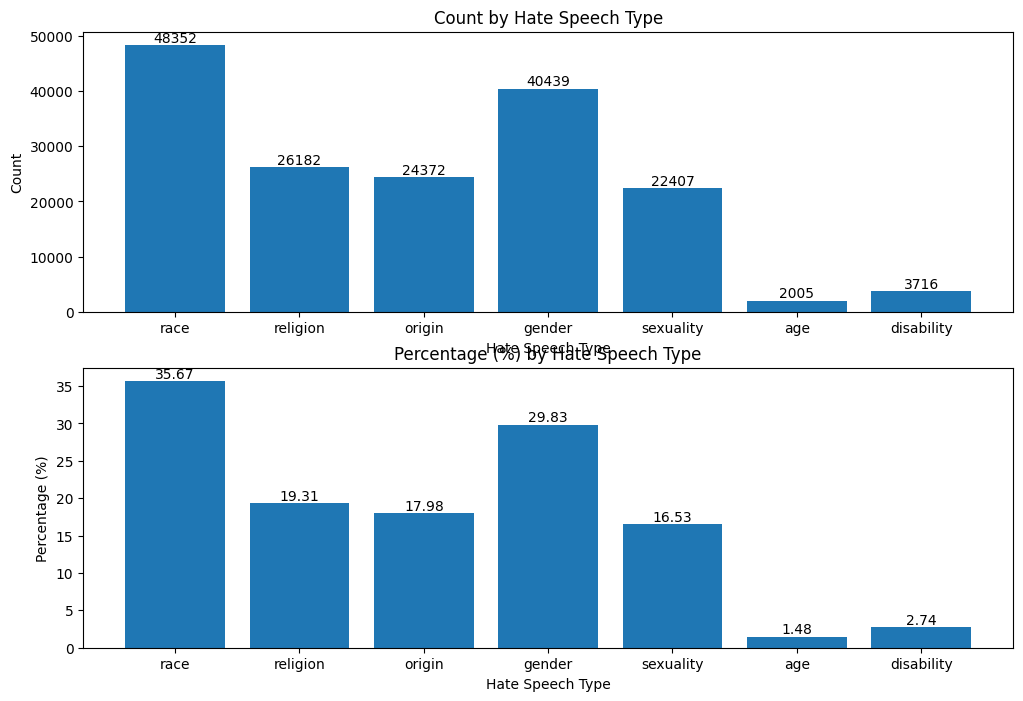

In [10]:
# create 2 graphs
fig, axs = plt.subplots(2, figsize=(12,8))

# create bar graphs of label counts
bar_container0 = axs[0].bar(label_counts.keys(), label_counts.values())
axs[0].bar_label(bar_container0, label_type='edge')
axs[0].set_xlabel('Hate Speech Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Count by Hate Speech Type')

# create bar graphs of label percentages
bar_container1 = axs[1].bar(label_percentages.keys(), label_percentages.values())
axs[1].bar_label(bar_container1, label_type='edge')
axs[1].set_xlabel('Hate Speech Type')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Percentage (%) by Hate Speech Type')

plt.show()

In [11]:
def create_labels(batch):
    # one-hot encode targets for training
    batch['labels'] = [[float(batch[label][i]) for label in LABEL2ID] for i in range(len(batch['text']))]
    return batch

preprocessed_datasets = preprocessed_datasets.map(create_labels, batched=True, remove_columns=LABEL2ID.keys())
preprocessed_datasets

  0%|          | 0/136 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 135556
    })
})

# Setup Model Training

## Create Train/Val/Test Dataset Splits

In [14]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [15]:
# train (80%), validation (10%), test (10%) split
train_test_datasets = preprocessed_datasets['train'].train_test_split(test_size=0.2, seed=SEED, shuffle=True)
validation_test_datasets = train_test_datasets['test'].train_test_split(test_size=0.5, seed=SEED, shuffle=True)

preprocessed_datasets = DatasetDict({
    'train': train_test_datasets['train'],
    'validation': validation_test_datasets['train'],
    'test': validation_test_datasets['test']
})
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 108444
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 13556
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 13556
    })
})

## Tokenize Dataset

In [16]:
CHECKPOINT = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
tokenized_datasets = preprocessed_datasets.map(lambda batch: tokenizer(batch['text'], truncation=True), batched=True, remove_columns=['text'])
tokenized_datasets

  0%|          | 0/109 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 108444
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 13556
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 13556
    })
})

In [21]:
tokenized_datasets["train"]["attention_mask"][0]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## Setup DataLoaders

In [22]:
# get data collator for data loader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# setup dataloaders with tokenized dataset
# to shuffle only be train for each epoch
# in 64 batch sizes with dynamic padding

dataloaders = {}
for dataset_type in tokenized_datasets.keys():
    dataloaders[dataset_type] = DataLoader(
        dataset=tokenized_datasets[dataset_type],
        batch_size=64,
        shuffle=(dataset_type == 'train'),
        collate_fn=data_collator,
    )

## Get Current Device

In [23]:
# get current device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Clone UnFine-Tuned Model

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(
    CHECKPOINT,
    problem_type='multi_label_classification',
    num_labels=len(LABEL2ID),
    label2id=LABEL2ID,
    id2label=ID2LABEL,
)

# move model to device
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [25]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "race",
    "1": "religion",
    "2": "origin",
    "3": "gender",
    "4": "sexuality",
    "5": "age",
    "6": "disability"
  },
  "initializer_range": 0.02,
  "label2id": {
    "age": 5,
    "disability": 6,
    "gender": 3,
    "origin": 2,
    "race": 0,
    "religion": 1,
    "sexuality": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.33.0",
  "vocab_size": 30522
}

## Setup Optimizer and Scheduler

In [26]:
# setup optimizer and scheduler
scheduler_name = 'linear'
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0, no_deprecation_warning=True)
num_training_epochs = 2
num_training_steps = num_training_epochs * len(dataloaders['train'])
num_warmup_steps = 0
lr_scheduler = get_scheduler(
    name=scheduler_name,
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

print(f"           SCHEDULER NAME: {scheduler_name}")
print(f"                OPTIMIZER: {optimizer.__class__.__name__}")
print(f"NUMBER OF TRAINING EPOCHS: {num_training_epochs}")
print(f" NUMBER OF TRAINING STEPS: {num_training_steps}")

           SCHEDULER NAME: linear
                OPTIMIZER: AdamW
NUMBER OF TRAINING EPOCHS: 2
 NUMBER OF TRAINING STEPS: 3390


## Setup Training Metrics

In [27]:
def samples_accuracy_score(y_true, y_pred):
    return np.sum(y_true==y_pred) / y_true.size

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = torch.nn.functional.sigmoid(torch.Tensor(logits))
    predictions = (predictions >= 0.50).int().numpy()
    samples_accuracy = samples_accuracy_score(labels, predictions)
    samples_f1 = f1_score(labels, predictions, average='samples', zero_division=0)
    return {
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

## Setup Training and Evaluation Scripts

In [28]:
def train(model, dataloader):
    # setup train metrics
    loss = 0
    train_predictions = []
    train_labels = []

    # set to train mode
    model.train()
    # iterate through dataloader
    for batch in tqdm(dataloader):
        # zero the gradients
        optimizer.zero_grad()

        # predict batch in current device
        batch.to(device)
        outputs = model(**batch)

        # compute multilabel outputs
        predictions = torch.nn.functional.sigmoid(outputs.logits).cpu()
        predictions = (predictions >= 0.50).int().numpy()
        labels = batch['labels']

        # backprop and update learning rate
        outputs.loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # accumulate train metrics
        loss += outputs.loss.item()
        train_predictions += predictions.tolist()
        train_labels += labels.tolist()

    # compute train metrics
    loss /= len(dataloader)
    samples_accuracy = samples_accuracy_score(np.array(train_labels), np.array(train_predictions))
    samples_f1 = f1_score(np.array(train_labels), np.array(train_predictions), average='samples', zero_division=0)
    return {
        'loss': loss,
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

In [29]:
def evaluate(model, dataloader):
    # setup evaluation metrics variables
    loss = 0
    evaluate_predictions = []
    evaluate_labels = []

    # set to evaluation mode
    model.eval()
    with torch.no_grad():
        # iterate through dataloader
        for batch in tqdm(dataloader):
            # predict batch in current device
            batch.to(device)
            outputs = model(**batch)

            # compute multilabel outputs
            predictions = torch.nn.functional.sigmoid(outputs.logits).cpu()
            predictions = (predictions >= 0.50).cpu().numpy()
            labels = batch['labels']

            # accumulate evaluation metrics
            loss += outputs.loss.item()
            evaluate_predictions += predictions.tolist()
            evaluate_labels += labels.tolist()

    # compute evaluation metrics
    loss /= len(dataloader)
    samples_accuracy = samples_accuracy_score(np.array(evaluate_labels), np.array(evaluate_predictions))
    samples_f1 = f1_score(np.array(evaluate_labels), np.array(evaluate_predictions), average='samples', zero_division=0)
    return {
        'loss': loss,
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

# Train Model

In [31]:
for epoch in range(num_training_epochs):
    train_metrics = train(model, dataloaders['train'])
    validation_metrics = evaluate(model, dataloaders['validation'])

    print(f"EPOCH {epoch+1}", end=" | ")
    print(f"TRAIN LOSS: {train_metrics['loss']:.5f}", end=" | ")
    print(f"VALIDATION LOSS: {validation_metrics['loss']:.5f}", end=" | ")
    print(f"VALIDATION ACCURACY: {validation_metrics['accuracy']:.5f}", end=" | ")
    print(f"VALIDATION F1: {validation_metrics['f1']:.5f}")

  0%|          | 0/1695 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.17805 | VALIDATION LOSS: 0.15490 | VALIDATION ACCURACY: 0.93841 | VALIDATION F1: 0.83583


  0%|          | 0/1695 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

EPOCH 2 | TRAIN LOSS: 0.14676 | VALIDATION LOSS: 0.15224 | VALIDATION ACCURACY: 0.93872 | VALIDATION F1: 0.83849


## Get Fine-Tuned Metrics

In [32]:
test_metrics = evaluate(model, dataloaders['test'])
print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" | ")
print(f"TEST F1: {test_metrics['f1']:.5f}")

  0%|          | 0/212 [00:00<?, ?it/s]

TEST ACCURACY: 0.93764 | TEST F1: 0.83304


# Let's try out some examples

In [34]:
from transformers import pipeline

# setup pipeline as a text classification with multilabel outputs
hate_speech_multilabel_classifier = pipeline(
    task='text-classification',
    model=model,
    tokenizer=tokenizer,
    device=torch.cuda.current_device(),
    top_k=None
)

In [43]:
raw_datasets["train"]["text"][9990]

'You have to be a particularly sick person to believe refugees like this women and these men and fathers have to be treated so inhumanly by caging them and taking away thier kids that is sanctioned by the Trump Pence administration URL'

In [46]:
religion_hate_text = """
There are some people who are raised on the school of a particular Imam,
sought a ruling from a particular jurist, or heard a particular anecdote from some scholars,
then wants to make all Muslims follow that." ~ Ibn Taymiya URL
"""

hate_speech_multilabel_classifier(religion_hate_text)

[[{'label': 'religion', 'score': 0.9501574039459229},
  {'label': 'race', 'score': 0.158457413315773},
  {'label': 'origin', 'score': 0.04607326537370682},
  {'label': 'gender', 'score': 0.003914115019142628},
  {'label': 'sexuality', 'score': 0.0007869629771448672},
  {'label': 'age', 'score': 0.0006876116385683417},
  {'label': 'disability', 'score': 0.0006789584876969457}]]

In [45]:
race_hate_text = """
is y'all even breathing enough for another vikvaughny visual wtfff🌚finna blow y'all niggers away.
"""

hate_speech_multilabel_classifier(race_hate_text)

[[{'label': 'race', 'score': 0.9944686889648438},
  {'label': 'gender', 'score': 0.01689913310110569},
  {'label': 'origin', 'score': 0.006208278704434633},
  {'label': 'sexuality', 'score': 0.0023396804463118315},
  {'label': 'age', 'score': 0.0020675193518400192},
  {'label': 'disability', 'score': 0.001897525042295456},
  {'label': 'religion', 'score': 0.0014750141417607665}]]

In [44]:
origin_hate_text = """
You have to be a particularly sick person to believe refugees like this women and these men
and fathers have to be treated so inhumanly by caging them and taking away thier kids that is sanctioned by the Trump Pence administration URL
"""

hate_speech_multilabel_classifier(origin_hate_text)

[[{'label': 'origin', 'score': 0.8950955271720886},
  {'label': 'gender', 'score': 0.29602137207984924},
  {'label': 'race', 'score': 0.16406109929084778},
  {'label': 'age', 'score': 0.02795323356986046},
  {'label': 'religion', 'score': 0.018652942031621933},
  {'label': 'sexuality', 'score': 0.014542752876877785},
  {'label': 'disability', 'score': 0.010641716420650482}]]